<a href="https://colab.research.google.com/github/JakobSchauser/QNCA/blob/main/QNCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric


In [ ]:
import torch
from torch_geometric.data import Data
import numpy as np


usegpu = False

device = torch.device('cuda' if torch.cuda.is_available() and usegpu else 'cpu')
print(device)

cpu


In [ ]:
from typing import Callable, Optional, Union

import torch
from torch import Tensor


import torch_geometric.typing
from typing import Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset
from torch_geometric.utils import scatter

from torch_geometric.typing import Adj, OptTensor, PairOptTensor, PairTensor, OptPairTensor, Size
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

import matplotlib.pyplot as plt
import inspect

def print2(*msg):
    frame = inspect.currentframe().f_back
    print(f"[LINE {frame.f_lineno}]", *msg)


class CustomEdgeConv(MessagePassing):
    def __init__(self, in_features, hidden_dim, out_dim=3):
        super().__init__(aggr=None)  # no aggregation, we just compute edge outputs
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim),
            # nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            # nn.Tanh()
        ).to(device)


    def forward(self, x, edge_index):
        # # Ensure undirected by sorting (min, max) node indices
        # src, dst = edge_index
        # undirected_edges = torch.stack([
        #     torch.min(src, dst),
        #     torch.max(src, dst)
        # ], dim=0)

        # # Remove duplicate edges
        # undirected_edges, unique_idx = torch.unique(undirected_edges, dim=1, return_inverse=True)

        # Build edge features: concat(node_u, node_v)
        u, v = edge_index
        # edge_feat = torch.cat([x[u], x[v]], dim=-1)
        edge_feat = (x[u] - x[v])

        # Predict 3 features per undirected edge
        edge_out = self.mlp(edge_feat)  # [num_undirected_edges, out_dim]

        # fixed_out = torch.empty_like(edge_out)

        edge_out[:,0] = nn.Tanh()(edge_out[:,0])*2.*torch.pi
        # normalize
        magnitude = torch.linalg.norm(edge_out[:,1:], dim=1, keepdim=True) + 1e-11

        # edge_out = edge_out / torch.cat( [torch.ones_like(edge_out[:,0][:,None], device = device), magnitude, magnitude], dim=1)


        node_out = self.edge_out_to_node_out_avg(edge_out, edge_index)

        return node_out # [num_nodes, out_dim]

    def edge_out_to_node_out_directional(self, edge_out, edge_index, reduce='sum'):
        u, v = edge_index  # u -> v (source -> target)

        # Aggregate to target nodes (incoming edges)
        node_out = scatter(edge_out, v, dim=0, dim_size=None, reduce=reduce)

        return node_out


    def edge_out_to_node_out_avg(self, edge_out, edge_index, reduce='sum'):
        u, v = edge_index  # u -> v (source -> target)

        # edge_out.shape [n_edge, out_dim]

        # print2(edge_out[u == 0])
        # print2(edge_out[v == 0])

        # Aggregate to target nodes (incoming edges)
        node_out1 = scatter(edge_out, u, dim=0, dim_size=None, reduce=reduce)
        node_out2 = scatter(edge_out, v, dim=0, dim_size=None, reduce=reduce)

        # print2(node_out1.shape) # [num_nodes, out_dim]
        # print2(node_out1[0])
        # print2(node_out2[0])

        # print2((node_out1 - node_out2)[0])

        return (node_out1 - node_out2)


class CustomGraphConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        aggr: str = 'add',
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_rel = Linear(in_channels[0], out_channels, bias=bias)
        self.lin_root = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_rel.reset_parameters()
        self.lin_root.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_weight: OptTensor = None, size: Size = None) -> Tensor:

        if isinstance(x, Tensor):
            x = (x, x)

        out_1 = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=size)

        # print2(out_1.shape)  # [N_cells, 3]

        out = self.lin_rel(out_1)

        x_r = out_1

        assert x_r is not None, "x_r is None"
        # if x_r is not None:
        out = out + self.lin_root(x_r)

        return out

    def message(self, x_i : Tensor, x_j :Tensor, edge_weight: OptTensor) -> Tensor:

        x = (x_j - x_i)
        # print2(x.shape) # [N_cells * N_nbs, 3])

        return x if edge_weight is None else edge_weight.view(-1, 1) * x

    # def aggregate(self, inputs, index, ptr=None, dim_size=None):
    #     return inputs, index

    # def message_and_aggregate(self, adj_t: Adj, x: OptPairTensor) -> Tensor:
    #     return spmm(adj_t, x[0], reduce=self.aggr)


class CustomGNN(torch.nn.Module):
    def __init__(self, hidden_dims,):
        super(CustomGNN, self).__init__()

        if type(hidden_dims) is not list:
            hidden_dims = [hidden_dims]


        # NN = nn.Sequential(nn.Linear(2, 6), nn.ReLU(), nn.Linear(6, 6), nn.ReLU(), nn.Linear(6, hidden_dims[0]))

        # convolutional layer
        # self.input_layer = CustomEdgeConv(NN)
        self.input_layer = CustomGraphConv(3, hidden_dims[0])

        self.hidden_layers = torch.nn.ModuleList()
        self.activation_func = F.relu

        for i in range(len(hidden_dims)-1):
            _in = hidden_dims[i]
            _out = hidden_dims[i+1]

            self.hidden_layers.append(Linear(_in, _out))

        self.output_layer = Linear(hidden_dims[-1], 3, bias = True)


    def forward(self, feature_data, edge_info):
        x = self.input_layer(feature_data, edge_info)


        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation_func(x)  # Apply activation function to each hidden layer output

        x = self.output_layer(x, )

        return x

hidden_dims = [16, 16, 16]  # Hidden dimensions

# Initialize the CustomGNN model
# model = CustomGNN(hidden_dims)
model = CustomEdgeConv(3, 16, 3)

model = model.to(device)

In [ ]:
import torch
from torch_geometric.data import Data
# from torch_geometric.nn import knn_graph
from torch.nn.functional import pairwise_distance
from torch_geometric.utils import to_undirected
import random
import math
# Define a grid of agents
# grid_size = 10
# x = torch.linspace(0, grid_size, steps=10)
# y = torch.linspace(0, grid_size, steps=10)

# uniform within circle


def poisson_disk_sampling(radius=0.1, k=30, circle_radius=1.0):
    """
    Generates a set of points using Poisson Disk Sampling within a circle.

    Args:
        radius (float): Minimum distance between points.
        k (int): Number of attempts to find a new point around a sample.
        circle_radius (float): Radius of the circular sampling area.

    Returns:
        tuple: A tuple containing:
            - positions (torch.Tensor): Tensor of shape [num_agents, 2] with sampled positions.
            - num_agents (int): The number of sampled agents.
    """
    cell_size = radius / math.sqrt(2)
    grid_size = math.ceil(2 * circle_radius / cell_size)
    grid = [[None for _ in range(grid_size)] for _ in range(grid_size)]
    center_offset = torch.tensor([circle_radius, circle_radius], device=device)

    def is_in_circle(point, r):
        return (point[0]**2 + point[1]**2) <= r**2

    def get_grid_coords(point):
        grid_x = int((point[0] + circle_radius) / cell_size)
        grid_y = int((point[1] + circle_radius) / cell_size)
        return grid_x, grid_y

    # Start with a random initial point within the circle
    while True:
      start_x = 2 * circle_radius * random.random() - circle_radius
      start_y = 2 * circle_radius * random.random() - circle_radius
      start_point = (start_x, start_y)
      if is_in_circle(start_point, circle_radius):
        break

    active_list = [start_point]
    sample_points = [start_point]
    grid_x, grid_y = get_grid_coords(start_point)
    if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
        grid[grid_x][grid_y] = start_point


    while active_list:
        p = active_list.pop(random.randrange(len(active_list)))

        for _ in range(k):
            # Generate a random point in an annulus around p
            angle = 2 * math.pi * random.random()
            r = radius * (random.random() + 1)
            new_x = p[0] + r * math.cos(angle)
            new_y = p[1] + r * math.sin(angle)
            new_point = (new_x, new_y)

            # Check if the new point is within bounds and the circle
            if is_in_circle(new_point, circle_radius):
                grid_x, grid_y = get_grid_coords(new_point)

                # Check if the new point is too close to existing points in the neighborhood
                is_valid = True
                for i in range(max(0, grid_x - 2), min(grid_size, grid_x + 3)):
                    for j in range(max(0, grid_y - 2), min(grid_size, grid_y + 3)):
                        if grid[i][j] is not None:
                            dist = math.dist(new_point, grid[i][j])
                            if dist < radius:
                                is_valid = False
                                break
                    if not is_valid:
                        break

                # If valid, add to samples and active list
                if is_valid:
                    active_list.append(new_point)
                    sample_points.append(new_point)
                    if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
                        grid[grid_x][grid_y] = new_point

    positions = torch.tensor(sample_points, dtype=torch.float32, device=device)
    num_agents = positions.shape[0]

    return positions, num_agents

positions, num_agents = poisson_disk_sampling(circle_radius=2.5, radius=0.2)

# for _ in range(num_agents):
#     theta = 2 * torch.pi * torch.rand(1)
#     r = torch.rand(1)**0.5 * int(np.sqrt(float(num_agents)/torch.pi**2)) * 0.25
#     x.append(r * torch.cos(theta))
#     y.append(r * torch.sin(theta))

# x = torch.tensor(x, device = device)
# y = torch.tensor(y, device = device)

# positions = torch.stack((x,y), dim=-1).view(-1, 2)

angle_feature_data = 2 * torch.pi * torch.rand(num_agents, 1, device = device)

print2(angle_feature_data.shape, positions.shape)
feature_data = torch.cat([angle_feature_data, positions[:,0].unsqueeze(1), positions[:,1].unsqueeze(1),], dim=1)

feature_data = feature_data.to(device)
print2(feature_data.shape)


# Define the graph using k-NN (manual implementation)


def knn_with_cutoff(x, k=8, cutoff=1.0, self_loops=False):
    N, D = x.shape

    # pairwise squared distances
    dist2 = torch.cdist(x, x, p=2) ** 2

    # mask self-distances (unless self_loops=True)
    if not self_loops:
        dist2.fill_diagonal_(float("inf"))

    # get k nearest neighbors
    dist, idx = torch.topk(dist2, k, largest=False)

    # cutoff mask
    mask = dist <= cutoff**2

    # source nodes (repeat each index k times)
    row = torch.arange(N, device=x.device).repeat_interleave(k)
    col = idx.reshape(-1)
    mask_flat = mask.reshape(-1)

    # # apply cutoff mask
    row = row[mask_flat]
    col = col[mask_flat]

    edge_index = torch.stack([row, col], dim=0)

    edge_index = to_undirected(edge_index, num_nodes=N)

    return edge_index

from torch_geometric.utils import to_undirected
from scipy.spatial import Delaunay

def voronoi_neighbohrs(x, cutoff=None):
    """
    Construct Voronoi neighbors (dual of Delaunay triangulation).

    x: [N, D] torch.Tensor of point coordinates (D must be 2 or 3 typically)
    cutoff: optional float, only keep edges <= cutoff distance

    Returns:
        edge_index: [2, E] tensor of undirected edges
    """
    X = x.detach().cpu().numpy()
    N, D = X.shape

    if D < 2:
        raise ValueError("Voronoi neighbors require at least 2D points")

    # Compute Delaunay triangulation
    tri = Delaunay(X)

    # Collect edges from simplices
    edges = set()
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                a, b = simplex[i], simplex[j]
                edges.add((a, b))
                edges.add((b, a))

    edges = np.array(list(edges)).T  # [2, E]
    edge_index = torch.tensor(edges, dtype=torch.long, device = device)

    # Make undirected (removes duplicate pairs)
    edge_index = to_undirected(edge_index, num_nodes=N)

    # Apply cutoff if requested
    if cutoff is not None:
        src, dst = edge_index
        dists = torch.norm(x[src] - x[dst], dim=1)
        mask = dists <= cutoff
        edge_index = edge_index[:, mask]

    return edge_index

# update_edge_index = lambda x: knn_with_cutoff(x, k=10, cutoff=5.0)
update_edge_index = lambda x: voronoi_neighbohrs(x, cutoff=5.0)

edge_index = update_edge_index(positions)

[LINE 112] torch.Size([315, 1]) torch.Size([315, 2])
[LINE 116] torch.Size([315, 3])


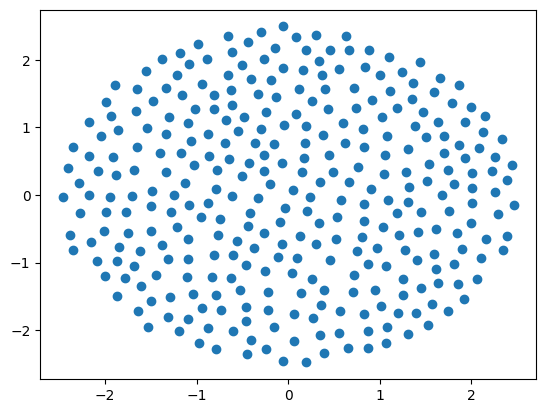

In [ ]:
plt.scatter(positions[:,0], positions[:,1])

In [ ]:
num_agents

315

In [ ]:
(edge_index == 21).sum(axis = 1)

tensor([6, 6])

# Task
Create a Python class that trains agents to align their "feature data" using a custom GNN with a k-nearest neighbors (KNN) graph, allowing for the use of different KNN implementations.

In [ ]:
edge_index

tensor([[  0,   0,   0,  ..., 314, 314, 314],
        [  1,   2,   3,  ..., 311, 312, 313]])

In [ ]:
input_features = 3
model = CustomEdgeConv(input_features, 16)
x = torch.randn(num_agents, input_features, device = device)  # node embeddings

out = model(x, edge_index)

In [ ]:
out.shape

torch.Size([315, 3])

In [ ]:
edge_index.shape

torch.Size([2, 1824])

In [ ]:
def alignment_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    # print2(target_features.shape) # shape [ncells * n_nbs, n_features]
    # Calculate mean squared error between connected nodes
    loss = F.mse_loss(source_features[:,0], target_features[:,0])
    return loss


def width_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    maxx = torch.max(source_features[:,1])
    minx = torch.min(source_features[:,1])
    # print2(target_features.shape) # shape [ncells * n_nbs, n_features]
    # Calculate mean squared error between connected nodes
    loss = maxx - minx
    return -loss



def height_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    maxy = torch.max(source_features[:,2])
    miny = torch.min(source_features[:,2])
    # print2(target_features.shape) # shape [ncells * n_nbs, n_features]
    # Calculate mean squared error between connected nodes
    loss = maxy - miny
    return loss

def extend_loss(current_feature_data, edge_index):
    # Extract source and target node features
    # source_nodes = edge_index[0]
    # source_features = current_feature_data[source_nodes]
    X = current_feature_data[:, 1:]                          # [N, D]

    # Full pairwise Euclidean distances: [N, N]
    dists = torch.cdist(X, X, p=2)

    # find median distance between any two
    median_dist = -torch.max(dists)


    return median_dist



def dist_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    source_positions = source_features[:,1:]
    target_positions = target_features[:,1:]

    X = source_features[:, 1:]                          # [N, D]
    Y = target_features[:, 1:]                          # [N, D]


    # Full pairwise Euclidean distances: [N, N]
    dists = torch.linalg.norm(X - Y, dim = 1)


    # dists = torch.minimum(dists, torch.ones_like(dists)*0.2)

    # find median distance between any two
    median_dist = -torch.mean(dists)


    return median_dist

def uniform_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    dists = torch.linalg.norm(source_features[:,1:] - target_features[:,1:], dim = 1)

    offdists = dists - 0.5

    whenzero = (offdists < 0. + 1.0)
    how_far_from_uniform = torch.abs(offdists*whenzero).mean()



    return how_far_from_uniform


def get_slice_area(a, b, theta):
    assert all(theta != torch.pi), "No right angles, please"

    h = b*torch.sin(theta)

    denom = (a-b/(torch.cos(theta) + 1e-10))
    assert not torch.isnan(denom).any(), "NaNs in denom"

    k = (a-b*torch.cos(theta))/ (denom + 1e-10)

    A = 1/2*h*(b*torch.sin(theta)  + h*torch.tan(theta) - k*k)

    assert not torch.isnan(A).any(), "NaNs in A"
    return A


def subtract_two_angles(angle1, angle2):
    return (angle1 - angle2 + torch.pi) % (2 * torch.pi) - torch.pi

def area_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    positions    = source_features[:,1:]

    nb_positions = target_features[:,1:]

    # any nans?
    assert not torch.isnan(positions).any(), "NaNs in positions"
    assert not torch.isnan(nb_positions).any(), "NaNs in nb_positions"

    midpoints = (positions + nb_positions) / 2.


    local_midpoints = midpoints - positions

    # any_nans?
    assert not torch.isnan(local_midpoints).any(), "NaNs in local_midpoints"

    dists = torch.linalg.norm(local_midpoints, dim=1)

    angles = torch.atan2(local_midpoints[:,1], local_midpoints[:,0])


    dists_reshaped = dists.view(7,100)
    angles_reshaped = angles.view(7,100)

    # any nans?
    assert not torch.isnan(dists_reshaped).any(), "NaNs in dists"
    assert not torch.isnan(angles_reshaped).any(), "NaNs in angles"

    slice_area0 = get_slice_area(dists_reshaped[0], dists_reshaped[1], subtract_two_angles(angles_reshaped[1], angles_reshaped[0]))
    slice_area1 = get_slice_area(dists_reshaped[1], dists_reshaped[2], subtract_two_angles(angles_reshaped[2], angles_reshaped[1]))
    slice_area2 = get_slice_area(dists_reshaped[2], dists_reshaped[3], subtract_two_angles(angles_reshaped[3], angles_reshaped[2]))
    slice_area3 = get_slice_area(dists_reshaped[3], dists_reshaped[4], subtract_two_angles(angles_reshaped[4], angles_reshaped[3]))
    slice_area4 = get_slice_area(dists_reshaped[4], dists_reshaped[5], subtract_two_angles(angles_reshaped[5], angles_reshaped[4]))
    slice_area5 = get_slice_area(dists_reshaped[5], dists_reshaped[6], subtract_two_angles(angles_reshaped[6], angles_reshaped[5]))
    slice_area6 = get_slice_area(dists_reshaped[6], dists_reshaped[0], subtract_two_angles(angles_reshaped[0], angles_reshaped[6]))

    slice_areas = torch.stack([slice_area0, slice_area1, slice_area2, slice_area3, slice_area4, slice_area5, slice_area6], dim=1)
    areas = torch.sum(slice_areas, dim=1)

    # any nan?
    assert not torch.isnan(areas).any(), "NaNs in areas"

    loss = -torch.mean(areas)

    # any nans?
    assert not torch.isnan(loss).any(), "NaNs in loss"

    return loss
    # print2(dists.shape)




def dumb_donut(output, edge_index):
        # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    positions = output[:,1:]

    loss = torch.tensor([0.], requires_grad=True)
    # make sure noone is within 5 of the origin
    center_of_mass = torch.mean(positions, dim = 0)

    dist_from_origin = torch.linalg.norm(positions - center_of_mass, dim = 1)

    loss = (torch.tanh(dist_from_origin*2. - 8.) - torch.tanh(dist_from_origin*2. - 4.)).sum()
    # make sure everyone is far away from their nbs

    # dists = torch.linalg.norm(source_features[:,1:] - target_features[:,1:], dim = 1)

    # loss -= torch.sum(dists)*0.01

    return loss





## Implement the nca update rule

### Subtask:
Define a function that updates the agent's features based on the model's delta output and potentially a learning rate or other update parameters.


In [ ]:
def nca_update(feature_data, delta_output, learning_rate):
    """
    Updates agent features based on the model's delta output using NCA rules.

    Args:
        feature_data (torch.Tensor): The current feature data of the agents.
        delta_output (torch.Tensor): The delta output from the CustomGNN model.
        learning_rate (float): The learning rate for updating features.

    Returns:
        torch.Tensor: The updated feature data, wrapped to [0, 2*pi].
    """
    updated_feature_data = feature_data + delta_output * learning_rate
    # Wrap the feature data to be within [0, 2*pi]
    updated_feature_data[:,0] = updated_feature_data[:,0] % (2. * torch.pi)

    return updated_feature_data

def nca_update_angles(feature_data, delta_output, learning_rate):
    """
    Updates agent features based on the model's delta output using NCA rules.

    Args:
        feature_data (torch.Tensor): The current feature data of the agents.
        delta_output (torch.Tensor): The delta output from the CustomGNN model.
        learning_rate (float): The learning rate for updating features.

    Returns:
        torch.Tensor: The updated feature data, wrapped to [0, 2*pi].
    """

    delta_output[:,1:] = 0.

    updated_feature_data = feature_data + delta_output * learning_rate
    # Wrap the feature data to be within [0, 2*pi]

    updated_feature_data[:,0] = updated_feature_data[:,0] % (2. * torch.pi)

    return updated_feature_data

## Modify the training loop for nca

### Subtask:
Create a training loop that simulates multiple NCA steps within each epoch. In each epoch, perform several forward passes of the GNN, apply the update rule, and calculate the loss based on the alignment of features *after* these update steps.


**Reasoning**:
Implement the training loop with multiple NCA steps per epoch as described in the instructions.



In [ ]:
# delta_output = model(current_feature_data, edge_index)
# delta_output
0.5*(100*101)

5050.0

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.00001)


nca_steps = 150  # Number of NCA steps per epoch
nca_learning_rate = 0.01 # Learning rate for the NCA update

num_epochs = 2000



for epoch in range(num_epochs):
    model.train()

    current_feature_data = feature_data.clone().detach().requires_grad_(True) # Start with the initial features for each epoch

    # total_loss = torch.tensor([0.], requires_grad=True) # Initialize total loss for the epoch
    n_times_run = 1
    for _ in range(n_times_run):
        current_feature_data = current_feature_data.clone().detach().requires_grad_(True)
        optimizer.zero_grad()
        for step in range(nca_steps):
            # No need to detach and require_grad_ here if we want gradients to flow back
            # current_feature_data = current_feature_data.clone().detach().requires_grad_(True)

            delta_output = model(current_feature_data, edge_index)
            # any nans
            assert not torch.isnan(delta_output).any(), f"NaNs in delta_output at epoch {epoch}, step {step}"
            # print2(delta_output.shape)

            # Update feature data
            # This update needs to be part of the computation graph if we want to backpropagate through it
            current_feature_data = nca_update(current_feature_data, delta_output, nca_learning_rate)

            # Detaching here is necessary because we don't want to backpropagate through the k-NN calculation
            if (step+1) % 5 == 0:
                edge_index = update_edge_index(current_feature_data[:,1:].detach())

        # Calculate loss and perform optimizer step at the end of NCA steps if step_every_step is False  extend_loss(current_feature_data, edge_index) +
        # total_loss = torch.tensor([0.], requires_grad=True)# dist_loss(current_feature_data, edge_index)*50. + uniform_loss(current_feature_data, edge_index)*100
        total_loss =  dumb_donut(current_feature_data, edge_index) #+ dist_loss(current_feature_data, edge_index)
        total_loss.backward()
        optimizer.step()


        if (epoch + 1) % 100 == 0:
            # Print the average loss if accumulating per step, otherwise print the final loss
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')

Epoch [100/2000], Loss: -445.3883
Epoch [200/2000], Loss: -424.5330
Epoch [300/2000], Loss: -464.1663
Epoch [400/2000], Loss: -489.8672
Epoch [500/2000], Loss: -452.6693
Epoch [600/2000], Loss: -447.7416
Epoch [700/2000], Loss: -404.4785
Epoch [800/2000], Loss: -499.4434
Epoch [900/2000], Loss: -399.7509
Epoch [1000/2000], Loss: -321.2569
Epoch [1100/2000], Loss: -498.4994
Epoch [1200/2000], Loss: -454.6818
Epoch [1300/2000], Loss: -468.9149
Epoch [1400/2000], Loss: -479.5870
Epoch [1500/2000], Loss: -504.5759
Epoch [1600/2000], Loss: -452.8881
Epoch [1700/2000], Loss: -496.5730
Epoch [1800/2000], Loss: -503.3981
Epoch [1900/2000], Loss: -459.1251
Epoch [2000/2000], Loss: -497.0392


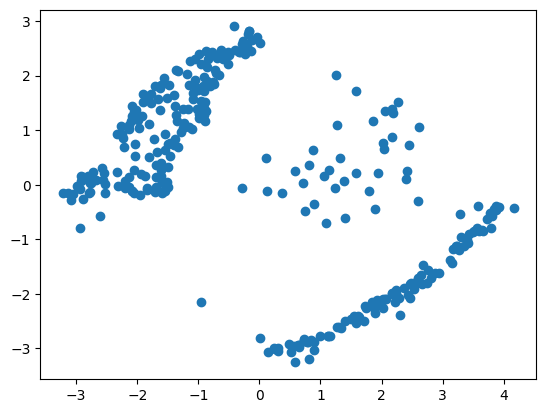

In [ ]:
# torch.autograd.set_detect_anomaly(False)
plt.scatter(current_feature_data[:,1].cpu().detach().numpy(), current_feature_data.cpu().detach().numpy()[:,2])


In [ ]:
# save the model
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# run the nca and get history

detach = lambda x: x.cpu().detach().numpy()


history = []

current_feature_data = feature_data.clone().detach().requires_grad_(True) # Start with the initial features for each epoch

for step in range(nca_steps):
    print(f"step {step}", end = "\r")
    delta_output = model(current_feature_data, edge_index)
    current_feature_data = nca_update(current_feature_data, delta_output, nca_learning_rate)
    edge_index = update_edge_index(current_feature_data[:,1:])
    history.append(detach(current_feature_data))




In [ ]:
# x, y = current_feature_data[:,1], current_feature_data[:,2]

# c = torch.tensor([0,0])

# current_feature_data[torch.linalg.norm( current_feature_data[:,1:]) < 0.5, 1] += 15.0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

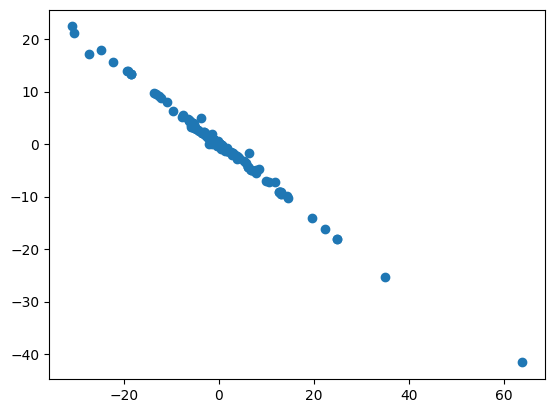

In [ ]:
o = detach(delta_output[:,1:])
plt.scatter(o[:,0], o[:,1])

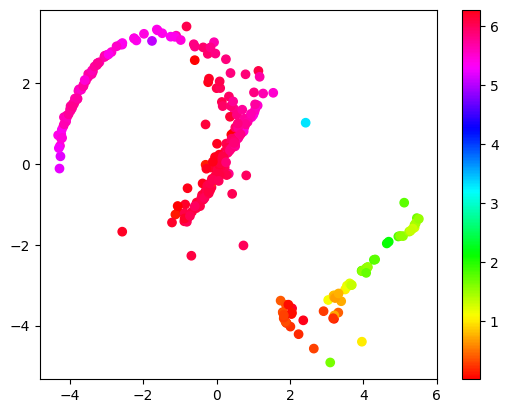

In [ ]:
curdata = history[-1][:,0]
curposs = history[-1][:,1:]
startdata = history[0][:,0]


plt.scatter(curposs[:, 0], curposs[:, 1], c=curdata, cmap='hsv')

arrows = [np.cos(curdata), np.sin(curdata)]
oldarrows = [np.cos(startdata), np.sin(startdata)]

# plt.quiver(curposs[:, 0], curposs[:, 1], oldarrows[0]*0.3, oldarrows[1]*0.3, color='blue', scale=10)
# plt.quiver(curposs[:, 0], curposs[:, 1], arrows[0]*0.5, arrows[1]*0.5, color='red', scale=10)
plt.colorbar()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Assuming 'history' is a list of tensors, where each tensor is the feature data at a step
# And assuming the first column of the feature data is the angle and the rest are positions

# 100 random colors

usehistory = np.array(history[::10])

colors = plt.cm.hsv(np.linspace(0, 1, num_agents))
x_min = np.min(usehistory[:,:, 0])
x_max = np.max(usehistory[:,:, 0])
y_min = np.min(usehistory[:,:, 1])
y_max = np.max(usehistory[:,:, 1])



w, h = x_max - x_min, y_max - y_min
max_side = max(w, h)


def update(frame_index):
    plt.clf()  # Clear the current figure
    current_frame = usehistory[frame_index]
    current_data = current_frame[:, 0]
    current_positions = current_frame[:, 1:]
    plt.scatter(current_positions[:, 0], current_positions[:, 1], c=colors, cmap = 'hsv')
    plt.quiver(current_positions[:, 0], current_positions[:, 1], np.cos(current_data), np.sin(current_data), color='black', scale=30)
    plt.title(f'NCA Step {frame_index}')
    # plt.colorbar(label='Angle')


    center_of_mass = np.mean(current_positions, axis=0)
    # plt.xlim(-5 + center_of_mass[0], 5 + center_of_mass[0])
    # plt.ylim(-5 + center_of_mass[1], 5 + center_of_mass[1])


    plt.xlim(center_of_mass[0] - max_side/1., center_of_mass[0] + max_side/1.)
    plt.ylim(center_of_mass[1] - max_side/1., center_of_mass[1] + max_side/1.)

fig = plt.figure(figsize=(7, 7))
ani = animation.FuncAnimation(fig, update, frames=len(usehistory), repeat=False)

# To display the video inline in the notebook
HTML(ani.to_html5_video())

# plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Assuming 'history' is a list of tensors, where each tensor is the feature data at a step
# And assuming the first column of the feature data is the angle and the rest are positions

# 100 random colors

usehistory = history[::3]

colors = plt.cm.hsv(np.linspace(0, 1, num_agents))

def update(frame_index):
    plt.clf()  # Clear the current figure
    current_frame = usehistory[frame_index]
    current_data = current_frame[:, 0]
    current_positions = current_frame[:, 1:]
    plt.scatter(current_positions[:, 0], current_positions[:, 1], c=colors, cmap = 'hsv')
    plt.quiver(current_positions[:, 0], current_positions[:, 1], np.cos(current_data), np.sin(current_data), color='black', scale=30)
    plt.title(f'NCA Step {frame_index}')
    # plt.colorbar(label='Angle')


    center_of_mass = np.mean(current_positions, axis=0)
    # plt.xlim(-5 + center_of_mass[0], 5 + center_of_mass[0])
    # plt.ylim(-5 + center_of_mass[1], 5 + center_of_mass[1])
    x_min = np.min(current_positions[:, 0])
    x_max = np.max(current_positions[:, 0])
    y_min = np.min(current_positions[:, 1])
    y_max = np.max(current_positions[:, 1])


    w, h = x_max - x_min, y_max - y_min
    max_side = max(w, h)

    plt.xlim(center_of_mass[0] - max_side/1.5, center_of_mass[0] + max_side/1.5)
    plt.ylim(center_of_mass[1] - max_side/1.5, center_of_mass[1] + max_side/1.5)

fig = plt.figure(figsize=(7, 7))
ani = animation.FuncAnimation(fig, update, frames=len(usehistory), repeat=False)

# To display the video inline in the notebook
HTML(ani.to_html5_video())